In [1]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, roc_auc_score,
    roc_curve, auc, make_scorer
)
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.metrics import precision_score, recall_score
import shap
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
import joblib
import numpy as np

c:\Users\nhatk\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
sentiment_columns = [
        'Reputation', 'Company Communication', 'Appointment', 'Financial', 'Regulatory',
        'Sales', 'M&A', 'Legal', 'Dividend Policy', 'Risks', 'Rumors', 'Strategy',
        'Options', 'IPO', 'Signal', 'Coverage', 'Fundamentals', 'Insider Activity',
        'Price Action', 'Buyside', 'Technical Analysis', 'Trade', 'Central Banks',
        'Currency', 'Conditions', 'Market', 'Volatility', 'Investor Sentiment', 'Retail Investor Behavior',
        'Speculation', 'Domestic Institutional Behavior', 'Foreign Institutional Behavior', 'Black Swan Event',
    ]

sentiment_p1d_columns = [
        'reputation_p1d', 'company_communication_p1d', 'appointment_p1d', 'financial_p1d', 'regulatory_p1d',
        'sales_p1d', 'm&a_p1d', 'legal_p1d', 'dividend_policy_p1d', 'risks_p1d', 'rumors_p1d', 'strategy_p1d',
        'options_p1d', 'ipo_p1d', 'signal_p1d', 'coverage_p1d', 'fundamentals_p1d', 'insider_activity_p1d',
        'price_action_p1d', 'buyside_p1d', 'technical_analysis_p1d', 'trade_p1d', 'central_banks_p1d',
        'currency_p1d', 'conditions_p1d', 'market_p1d', 'volatility_p1d', 'investor_sentiment_p1d', 'retail_investor_behavior_p1d',
        'speculation_p1d', 'domestic_institutional_behavior_p1d', 'foreign_institutional_behavior_p1d', 'black_swan_event_p1d',
    ]
meta_cols = ['num_sa_news', 'mean_sentiment_norm', 'max_sentiment_norm', 'std_sentiment_score', 'sum_positive_sa', 'sum_negative_sa', 'time_distance_from_sa_to_close_minutes']
meta_p1d_cols = ['num_sa_news_p1d', 'mean_sentiment_norm_p1d', 'max_sentiment_norm_p1d', 'std_sentiment_score_p1d', 'sum_positive_sa_p1d', 'sum_negative_sa_p1d', 'time_distance_from_sa_to_close_minutes_p1d']

sentiment_feature_selected =  sentiment_columns + sentiment_p1d_columns + meta_cols + meta_p1d_cols
ta_features = ['volume_ma','volume_to_volume_ma_ratio','ema_12','ema_26','sma_20','sma_50','roc_5','roc_1','roc_9','%K','%R','cci','obv','macd','signal_line','macd_histogram','rsi','rsi_base_ma','rsi_rsi_base_ma_ratio','bb_bbm','bb_bbh','bb_bbl','bb_bbp','bb_bbh_bb_bbl_ratio','hl_ratio', 'co_ratio', 'price_range', 'sma_ratio_20_50', 'ema_ratio_12_26', 'bb_width', 'bb_position', 'rsi_overbought', 'rsi_oversold', 'rsi_neutral', 'macd_bullish', 'momentum_5', 'momentum_10','log_return','volatility_5d','volatility_10d','volatility_20d','volatility_30d','mean_log_return_5d','mean_log_return_10d','mean_log_return_20d','mean_log_return_30d','sharpe_like_5d','sharpe_like_10d','sharpe_like_20d','sharpe_like_30d','up_streak','pos_log_return_ratio_20d','z_score_5d','z_score_10d','z_score_20d','z_score_30d','annual_return','daily_return','sharpe_ratio',
               'rsi_vn30','rsi_base_ma_vn30','rsi_rsi_base_ma_ratio_vn30','volume_ma_vn30','volume_to_volume_ma_ratio_vn30','bb_bbm_vn30','bb_bbh_vn30','bb_bbl_vn30','bb_bbp_vn30','bb_bbh_bb_bbl_ratio_vn30','roc_1_vn30', 'roc_5_vn30', 'roc_9_vn30','%K_vn30','%R_vn30','cci_vn30','obv_vn30','ema_12_vn30','ema_26_vn30','sma_20_vn30','sma_50_vn30', 'hl_ratio_vn30', 'co_ratio_vn30', 'price_range_vn30', 'sma_ratio_20_50_vn30', 'ema_ratio_12_26_vn30', 'bb_width_vn30', 'bb_position_vn30', 'rsi_overbought_vn30', 'rsi_oversold_vn30', 'rsi_neutral_vn30', 'momentum_5_vn30', 'momentum_10_vn30', 'log_return_vn30','volatility_5d_vn30','volatility_10d_vn30','volatility_20d_vn30','volatility_30d_vn30','mean_log_return_5d_vn30','mean_log_return_10d_vn30','mean_log_return_20d_vn30','mean_log_return_30d_vn30','sharpe_like_5d_vn30','sharpe_like_10d_vn30','sharpe_like_20d_vn30','sharpe_like_30d_vn30','up_streak_vn30','pos_log_return_ratio_20d_vn30','z_score_5d_vn30','z_score_10d_vn30','z_score_20d_vn30','z_score_30d_vn30','annual_return_vn30','daily_return_vn30','sharpe_ratio_vn30',
               'rsi_vni','rsi_base_ma_vni','rsi_rsi_base_ma_ratio_vni','volume_ma_vni','volume_to_volume_ma_ratio_vni','bb_bbm_vni','bb_bbh_vni','bb_bbl_vni','bb_bbp_vni','bb_bbh_bb_bbl_ratio_vni','roc_1_vni', 'roc_5_vni', 'roc_9_vni','%K_vni','%R_vni','cci_vni','obv_vni','ema_12_vni','ema_26_vni','sma_20_vni','sma_50_vni', 'hl_ratio_vni', 'co_ratio_vni', 'price_range_vni', 'sma_ratio_20_50_vni', 'ema_ratio_12_26_vni', 'bb_width_vni', 'bb_position_vni', 'rsi_overbought_vni', 'rsi_oversold_vni', 'rsi_neutral_vni', 'momentum_5_vni', 'momentum_10_vni','log_return_vni','volatility_5d_vni','volatility_10d_vni','volatility_20d_vni','volatility_30d_vni','mean_log_return_5d_vni','mean_log_return_10d_vni','mean_log_return_20d_vni','mean_log_return_30d_vni','sharpe_like_5d_vni','sharpe_like_10d_vni','sharpe_like_20d_vni','sharpe_like_30d_vni','up_streak_vni','pos_log_return_ratio_20d_vni','z_score_5d_vni','z_score_10d_vni','z_score_20d_vni','z_score_30d_vni','annual_return_vni','daily_return_vni','sharpe_ratio_vni']
fa_features = ['p/b_previous_quarter', 'p/b_change_rate','p/b_change_rate_flag','p/e_previous_quarter','p/e_change_rate','p/e_change_rate_flag','p/s_previous_quarter','p/s_change_rate','p/s_change_rate_flag','p/cash_flow_previous_quarter','p/cash_flow_change_rate','p/cash_flow_change_rate_flag','eps_previous_quarter','eps_change_rate', 'eps_change_rate_flag','bvps_previous_quarter','bvps_change_rate', 'bvps_change_rate_flag','roe_previous_quarter','roe_change_rate','roe_change_rate_flag','roa_previous_quarter','roa_change_rate','roa_change_rate_flag','coefficient_p/b','coefficient_p/e','coefficient_p/s','coefficient_p/cash_flow','coefficient_eps','coefficient_bvps','coefficient_roe','coefficient_roa','distance_to_nearest_quarter']
ta_fa_feature_selected = ta_features + fa_features
features = ta_fa_feature_selected + sentiment_feature_selected

In [9]:
# Load scaler v√† model cho TA+FA
ft_scaler = joblib.load(r'D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\model_scaler\ft_scaler.pkl')
ft_xgb_model = joblib.load(r'D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\model_scaler\ft_xgb_model.pkl')

In [10]:
# Load scaler v√† model cho TA+FA+SA
fts_scaler = joblib.load(r'D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\model_scaler\fts_scaler.pkl')
fts_xgb_model = joblib.load(r'D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\model_scaler\fts_xgb_model.pkl')

In [7]:
# load test_data
def dataframe_to_x_y(df, feature, target):
  X_train, y_train = [], []
  X_val, y_val = [], []
  n = len(df)
  split_index = int(n * 0.8)
  X_train = df[feature][:split_index]
  y_train = df[target][:split_index]
  X_val = df[feature][split_index:]
  y_val = df[target][split_index:]
  return X_train, y_train, X_val, y_val


def load_data_for_analysis(tickers, folder_path):

    df_all = []

    for ticker in tickers:
        file_path = os.path.join(folder_path, f"{ticker}.xlsx")
        if os.path.exists(file_path):
            df = pd.read_excel(file_path)
            df["ticker"] = ticker  # th√™m c·ªôt ticker
            df_all.append(df)
        else:
            print(f"‚ö†Ô∏è Kh√¥ng t√¨m th·∫•y: {file_path}")

    # G·ªôp l·∫°i th√†nh 1 DataFrame
    df_global = pd.concat(df_all, ignore_index=True)
    print(f"‚úÖ ƒê√£ load xong {len(df_global)} d√≤ng d·ªØ li·ªáu t·ª´ {len(df_all)} c·ªï phi·∫øu.")
    return df_global

tickers = ['ACB', 'BCM', 'BID','BVH','CTG','FPT','GAS','GVR','HDB','HPG',
                    'LPB','MBB','MSN','MWG','PLX','SAB','SHB','SSB','SSI','STB',
                    'TCB','TPB','VCB','VHM','VIB','VIC','VJC','VNM','VPB','VRE']
# folder_path_train = r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\data\v6\stock_trend\train_data" 
folder_path_test = r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\data\v6\stock_trend\test_data" 
# df_global_train = load_data_for_analysis(tickers, folder_path_train)
df_global_test = load_data_for_analysis(tickers, folder_path_test)

‚úÖ ƒê√£ load xong 7380 d√≤ng d·ªØ li·ªáu t·ª´ 30 c·ªï phi·∫øu.


In [8]:
# Copy dataframe k·∫øt qu·∫£
df_result = df_global_test.copy()

In [9]:
# D·ª± ƒëo√°n v·ªõi m√¥ h√¨nh TA+FA
X_ft = df_global_test[ta_fa_feature_selected]
X_ft_scaled = ft_scaler.transform(X_ft)
df_result['ft_xgb_model_predict'] = ft_xgb_model.predict(X_ft_scaled)

In [10]:
# D·ª± ƒëo√°n v·ªõi m√¥ h√¨nh TA+FA+SA
X_fts = df_global_test[features]
X_fts_scaled = fts_scaler.transform(X_fts)
df_result['fts_xgb_model_predict'] = fts_xgb_model.predict(X_fts_scaled)

In [11]:
df_result.to_excel(r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\df_result_predict.xlsx", index=False)

In [12]:
# T·∫°o mask cho ng√†y kh√¥ng c√≥ tin t·ª©c (t·∫•t c·∫£ sentiment_feature_selected == 0)
no_news_mask = (df_result[sentiment_feature_selected].abs().sum(axis=1) == 0)
# T·∫°o mask cho ng√†y c√≥ tin t·ª©c (√≠t nh·∫•t 1 sentiment_feature_selected kh√°c 0)
has_news_mask = (df_result[sentiment_feature_selected].abs().sum(axis=1) > 0)

In [13]:
# ƒê·∫£m b·∫£o d·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c sort theo ticker v√† ng√†y (gi·∫£ s·ª≠ c√≥ c·ªôt 'date')
df_result_sorted = df_result.sort_values(['ticker', 'time']).reset_index(drop=True)

In [14]:
# T·∫°o c√°c m·∫£ng ƒë·ªÉ d·ªÖ truy c·∫≠p
tickers = df_result_sorted['ticker'].values
targets = df_result_sorted['target'].values
fts_preds = df_result_sorted['fts_xgb_model_predict'].values
ft_preds = df_result_sorted['ft_xgb_model_predict'].values
no_news = no_news_mask.values
has_news = has_news_mask.values

In [15]:
# Tr∆∞·ªùng h·ª£p 1: Tin t·ª©c ti√™u c·ª±c ƒë·∫£o chi·ªÅu t·ª´ Buy -> Sell
case1_rows = []
for i in range(1, len(df_result_sorted)):
    # C√πng ticker, ng√†y h√¥m tr∆∞·ªõc kh√¥ng c√≥ tin t·ª©c, h√¥m sau c√≥ tin t·ª©c
    if (tickers[i] == tickers[i-1]) and no_news[i-1] and has_news[i]:
        # H√¥m tr∆∞·ªõc: fts d·ª± b√°o Buy v√† ƒë√∫ng ground truth
        if fts_preds[i-1] == 2 and targets[i-1] == 2:
            # H√¥m sau: fts d·ª± b√°o Sell v√† ƒë√∫ng ground truth
            if fts_preds[i] == 0 and targets[i] == 0:
                # ft_xgb_model d·ª± ƒëo√°n sai (Buy ho·∫∑c Hold)
                if ft_preds[i] in [1, 2]:
                    case1_rows.append(i)

df_case1 = df_result_sorted.iloc[case1_rows].copy()

In [16]:
# Tr∆∞·ªùng h·ª£p 2: Tin t·ª©c t√≠ch c·ª±c ƒë·∫£o chi·ªÅu t·ª´ Sell -> Buy
case2_rows = []
for i in range(1, len(df_result_sorted)):
    if (tickers[i] == tickers[i-1]) and no_news[i-1] and has_news[i]:
        # H√¥m tr∆∞·ªõc: fts d·ª± b√°o Sell v√† ƒë√∫ng ground truth
        if fts_preds[i-1] == 0 and targets[i-1] == 0:
            # H√¥m sau: fts d·ª± b√°o Buy v√† ƒë√∫ng ground truth
            if fts_preds[i] == 2 and targets[i] == 2:
                # ft_xgb_model d·ª± ƒëo√°n sai (Sell ho·∫∑c Hold)
                if ft_preds[i] in [0, 1]:
                    case2_rows.append(i)

df_case2 = df_result_sorted.iloc[case2_rows].copy()

In [17]:
# L∆∞u ra file Excel n·∫øu mu·ªën
df_case1.to_excel(r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\case1_negative_news_effect.xlsx", index=False)
df_case2.to_excel(r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\case2_positive_news_effect.xlsx", index=False)

In [18]:
# Minh ch·ª©ng 1: C√≥ tin t·ª©c, fts ƒë√∫ng Buy, ft sai
mask_case1 = (
    (has_news_mask) &
    (df_result['fts_xgb_model_predict'] == 2) &
    (df_result['target'] == 2) &
    (df_result['ft_xgb_model_predict'] != 2)
)
df_evidence1 = df_result[mask_case1].copy()

# Minh ch·ª©ng 2: C√≥ tin t·ª©c, fts ƒë√∫ng Sell, ft sai
mask_case2 = (
    (has_news_mask) &
    (df_result['fts_xgb_model_predict'] == 0) &
    (df_result['target'] == 0) &
    (df_result['ft_xgb_model_predict'] != 0)
)
df_evidence2 = df_result[mask_case2].copy()

In [ ]:
df_evidence1.to_excel(r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\evidence_buy_news.xlsx", index=False)
df_evidence2.to_excel(r"D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\evidence_sell_news.xlsx", index=False)

In [3]:
df_evidence1 = pd.read_excel(r'D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\evidence_buy_news.xlsx')
df_evidence2 = pd.read_excel(r'D:\thacsi\TAILIEULUANVAN\code\PredictStock_TA_FA_SA - Copy\TA_FA_SA\model\data_experiment_predict\evidence_sell_news.xlsx')

In [4]:
import shap
import matplotlib.pyplot as plt

In [7]:
# L·∫•y d·ªØ li·ªáu ƒë·∫ßu v√†o cho m√¥ h√¨nh fts (TA+FA+SA) t∆∞∆°ng ·ª©ng v·ªõi c√°c d√≤ng minh ch·ª©ng
X_evidence1 = df_evidence1[features]
X_evidence2 = df_evidence2[features]

In [11]:
# Gi·∫£ s·ª≠ b·∫°n ƒë√£ load fts_scaler t·ª´ tr∆∞·ªõc
X_evidence1_scaled = fts_scaler.transform(X_evidence1)
X_evidence2_scaled = fts_scaler.transform(X_evidence2)

In [12]:
# T·∫°o explainer cho m√¥ h√¨nh fts_xgb_model
explainer = shap.TreeExplainer(fts_xgb_model)

In [13]:
# T√≠nh gi√° tr·ªã shap cho t·ª´ng minh ch·ª©ng
shap_values1 = explainer.shap_values(X_evidence1_scaled)

In [14]:
print(type(shap_values1))
print(np.shape(shap_values1))

<class 'numpy.ndarray'>
(108, 282, 3)


In [15]:
shap_values2 = explainer.shap_values(X_evidence2_scaled)

In [16]:
print(type(shap_values2))
print(np.shape(shap_values2))

<class 'numpy.ndarray'>
(97, 282, 3)


In [32]:
# Ki·ªÉm tra s·ªë feature ƒë·∫ßu v√†o
print("Shape X_evidence1:", X_evidence1.shape)
print("Shape X_evidence2:", X_evidence2.shape)
print("S·ªë l∆∞·ª£ng features:", len(features))
print("S·ªë l∆∞·ª£ng feature c·∫£m x√∫c:", len(sentiment_feature_selected))

Shape X_evidence1: (108, 282)
Shape X_evidence2: (97, 282)
S·ªë l∆∞·ª£ng features: 282
S·ªë l∆∞·ª£ng feature c·∫£m x√∫c: 80


In [17]:
# L·∫•y SHAP values cho class 2 (Buy) v√† class 0 (Sell)
# N·∫øu shap_values1 l√† list, m·ªói ph·∫ßn t·ª≠ l√† (n_samples, n_features)
shap_values1_class2 = shap_values1[:, :, 2]  # (108, 282)
shap_values2_class0 = shap_values2[:, :, 0]  # (97, 282)

In [40]:
print("Shape shap_values1_class2:", shap_values1_class2.shape)
print("Shape shap_values2_class0:", shap_values2_class0.shape)

Shape shap_values1_class2: (108, 282)
Shape shap_values2_class0: (97, 282)


In [18]:
# L·∫•y index c√°c feature c·∫£m x√∫c
sentiment_idx = [features.index(col) for col in sentiment_feature_selected]

# L·∫•y SHAP values c·ªßa c√°c feature c·∫£m x√∫c
shap_values1_sentiment = shap_values1_class2[:, sentiment_idx]  # (108, 80)
shap_values2_sentiment = shap_values2_class0[:, sentiment_idx]  # (97, 80)

print("Shape shap_values1_sentiment:", shap_values1_sentiment.shape)
print("Shape shap_values2_sentiment:", shap_values2_sentiment.shape)

Shape shap_values1_sentiment: (108, 80)
Shape shap_values2_sentiment: (97, 80)


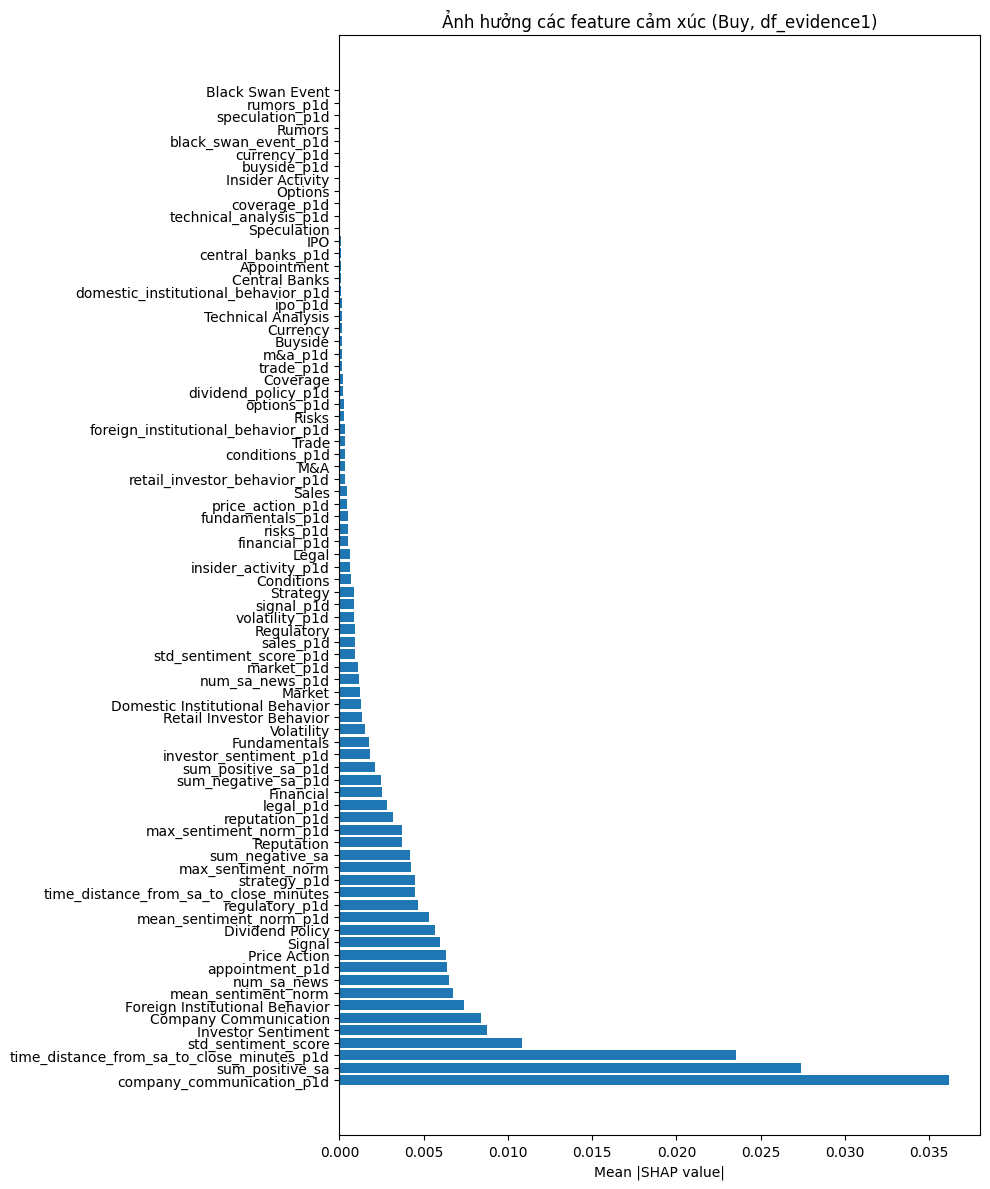

In [43]:
mean_abs_shap1 = np.abs(shap_values1_sentiment).mean(axis=0)
sorted_idx1 = mean_abs_shap1.argsort()[::-1]

plt.figure(figsize=(10, 12))
plt.barh(np.array(sentiment_feature_selected)[sorted_idx1], mean_abs_shap1[sorted_idx1])
plt.xlabel("Mean |SHAP value|")
plt.title("·∫¢nh h∆∞·ªüng c√°c feature c·∫£m x√∫c (Buy, df_evidence1)")
plt.tight_layout()
plt.show()

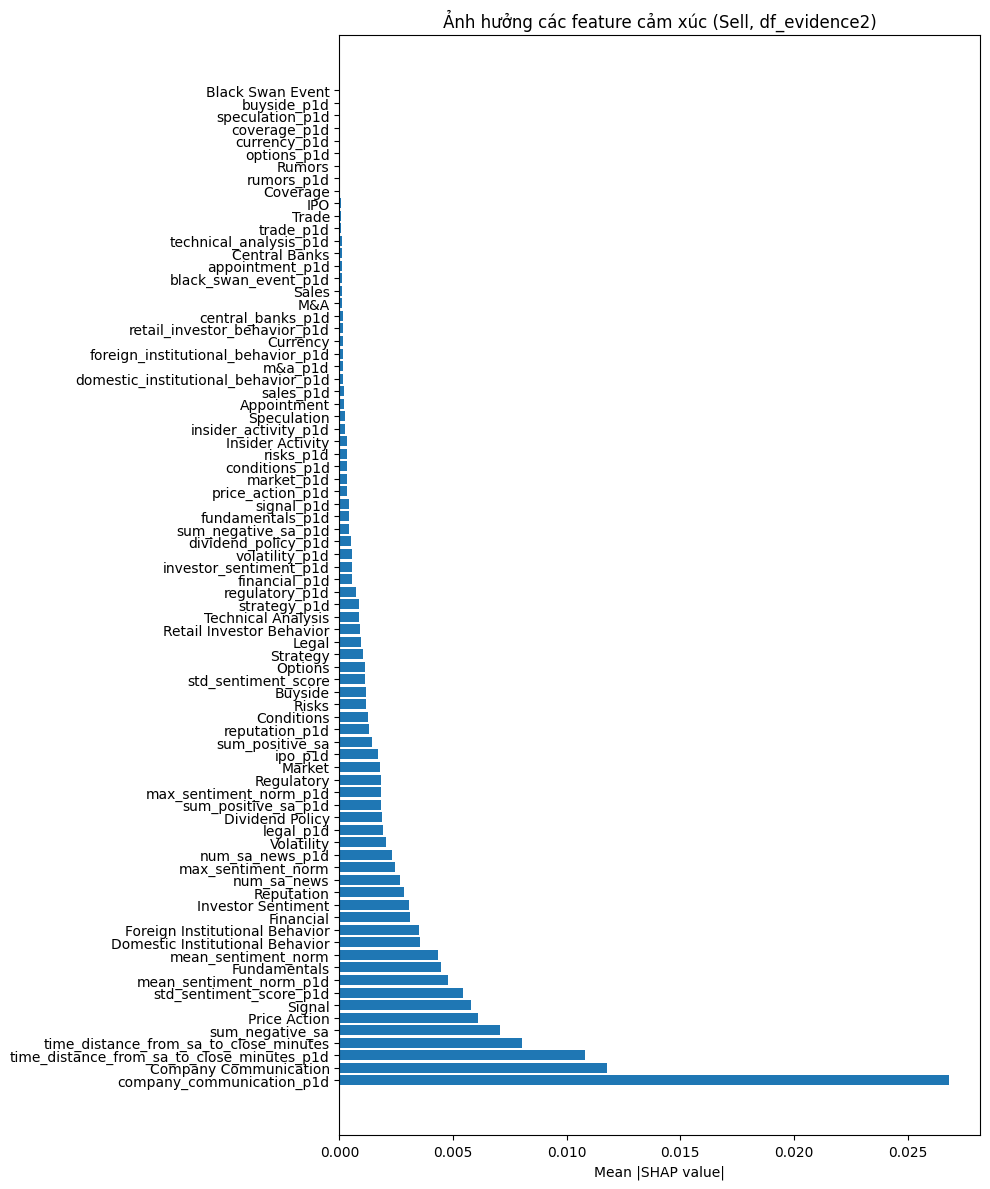

In [44]:
mean_abs_shap2 = np.abs(shap_values2_sentiment).mean(axis=0)
sorted_idx2 = mean_abs_shap2.argsort()[::-1]

plt.figure(figsize=(10, 12))
plt.barh(np.array(sentiment_feature_selected)[sorted_idx2], mean_abs_shap2[sorted_idx2])
plt.xlabel("Mean |SHAP value|")
plt.title("·∫¢nh h∆∞·ªüng c√°c feature c·∫£m x√∫c (Sell, df_evidence2)")
plt.tight_layout()
plt.show()

In [61]:
# Plot function
def safe_shap_plot(shap_vals, X, feature_names, class_idx, class_name):
    try:
        if shap_vals.ndim == 3:
            shap_for_class = shap_vals[:, :, class_idx]
        else:
            shap_for_class = shap_vals
        
        if shap_for_class.shape[1] == len(feature_names) + 1:
            shap_for_class = shap_for_class[:, :-1]
        
        n_features = min(shap_for_class.shape[1], X.shape[1], len(feature_names))
        X_df = pd.DataFrame(X[:, :n_features], columns=feature_names[:n_features])
        shap_plot_data = shap_for_class[:, :n_features]

        shap.summary_plot(
            shap_plot_data,
            X_df,
            show=False,
            max_display=5,
            color_bar=True  # Hi·ªÉn th·ªã m√†u
        )

        plt.title(f'Top 5 most influential sentiment features on {class_name} decision', fontsize=16, fontweight='bold')
        plt.xlabel('SHAP', fontsize=14)
        plt.ylabel('Feature', fontsize=14)

        # Ch√∫ th√≠ch m√†u s·∫Øc
        # plt.figtext(0.5, -0.05,
        #             'üîµ M√†u bi·ªÉu di·ªÖn gi√° tr·ªã feature: xanh = th·∫•p, h·ªìng = cao',
        #             ha='center', fontsize=13, color='black')

        plt.tight_layout()
        plt.show()
        return True

    except Exception as e:
        print(f"‚ùå Error for {class_name}: {e}")
        return False

In [ ]:
import matplotlib as mpl
# Set global font
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['font.size'] = 14

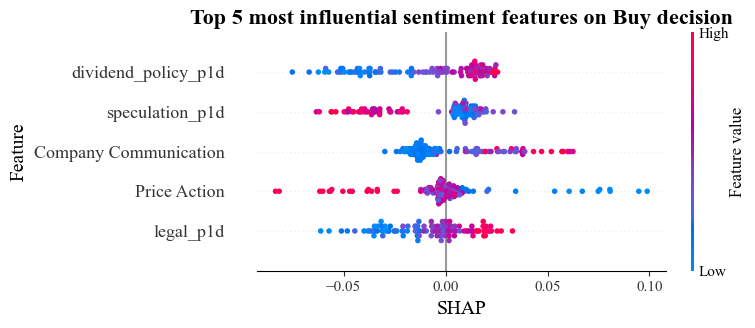

In [62]:
 success = safe_shap_plot(shap_values1, X_evidence1_scaled, sentiment_feature_selected, 2, 'Buy')

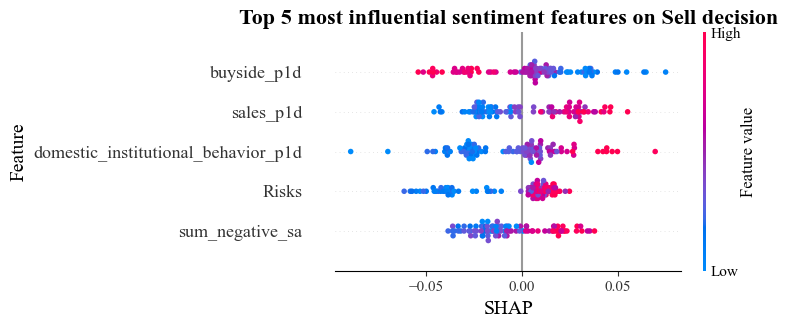

In [63]:
success = safe_shap_plot(shap_values2, X_evidence2_scaled, sentiment_feature_selected, 0, 'Sell')

In [68]:
# Plot function
def safe_shap_plot_custom_name(shap_vals, X, feature_names, class_idx, class_name, custom_names):
    try:
        if shap_vals.ndim == 3:
            shap_for_class = shap_vals[:, :, class_idx]
        else:
            shap_for_class = shap_vals
        
        if shap_for_class.shape[1] == len(feature_names) + 1:
            shap_for_class = shap_for_class[:, :-1]
        
        n_features = min(shap_for_class.shape[1], X.shape[1], len(feature_names))
        X_df = pd.DataFrame(X[:, :n_features], columns=feature_names[:n_features])
        shap_plot_data = shap_for_class[:, :n_features]

# T·∫°o figure ƒë·ªÉ l·∫•y th√¥ng tin feature quan tr·ªçng nh·∫•t
        plt.figure()
        shap.summary_plot(
            shap_plot_data,
            X_df,
            show=False,
            max_display=5,
            color_bar=True
        )
        ax = plt.gca()
        # L·∫•y t√™n feature g·ªëc tr√™n tr·ª•c y (top 5 feature)
        yticklabels = [tick.get_text() for tick in ax.get_yticklabels()]
        plt.close()  # ƒê√≥ng figure t·∫°m

        # T·∫°o mapping custom_names <-> feature g·ªëc
        if custom_names is None:
            custom_names = [str(i+1) for i in range(len(yticklabels))]
        mapping = {custom_names[i]: yticklabels[i] for i in range(len(yticklabels))}

        # ƒê·ªïi t√™n tr·ª•c y b·∫±ng custom_names
        plt.figure()
        shap.summary_plot(
            shap_plot_data,
            X_df,
            show=False,
            max_display=5,
            color_bar=False
        )
        ax = plt.gca()
        ax.set_yticklabels(custom_names)
        # L√†m ƒë·∫≠m t·ª´ng label tr·ª•c y
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')
        # plt.title(f'Top 5 most influential sentiment features on {class_name} decision', fontsize=16, fontweight='bold')
        plt.xlabel('SHAP', fontsize=14)
        # plt.ylabel('Feature', fontsize=14)
        # plt.tight_layout()
        ax.xaxis.label.set_visible(False)
        ax.tick_params(axis='x', labelsize=24)  # ch·ªânh k√≠ch th∆∞·ªõc s·ªë/t√™n tr·ª•c ho√†nh
        ax.tick_params(axis='y', labelsize=24)  # ch·ªânh k√≠ch th∆∞·ªõc s·ªë/t√™n tr·ª•c tung
        plt.show()

        print("Feature index mapping:")
        for k, v in mapping.items():
            print(f"{k}: {v}")

        return True


    except Exception as e:
        print(f"‚ùå Error for {class_name}: {e}")
        return False

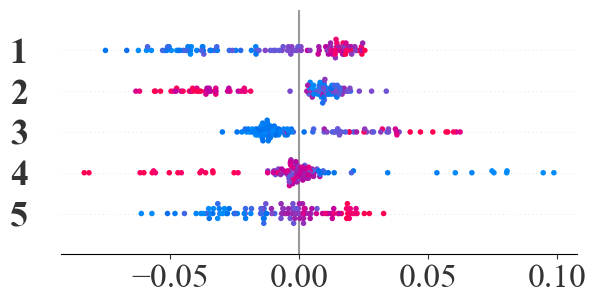

Feature index mapping:
5: legal_p1d
4: Price Action
3: Company Communication
2: speculation_p1d
1: dividend_policy_p1d


In [64]:
success = safe_shap_plot_custom_name(shap_values1, X_evidence1_scaled, sentiment_feature_selected, 2, 'Buy', custom_names=["5", "4", "3", "2", "1"])

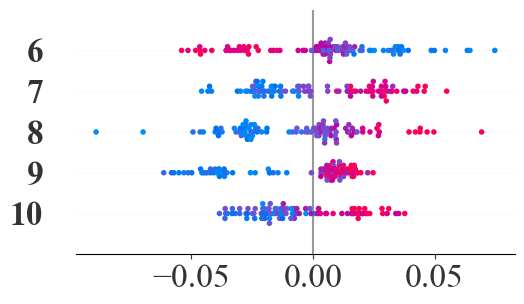

Feature index mapping:
10: sum_negative_sa
9: Risks
8: domestic_institutional_behavior_p1d
7: sales_p1d
6: buyside_p1d


In [69]:
success = safe_shap_plot_custom_name(shap_values2, X_evidence2_scaled, sentiment_feature_selected, 0, 'Sell', custom_names=["10", "9", "8", "7", "6"])